# Model Inference

In [81]:
# Imports
import cv2
import torch
import numpy as np
import os
from src.models.model_factory import SegModel
from src.sample import Sample
from src.utils import load_yaml

In [82]:
# Load the model from the checkpoint *.ckpt file
checkpoint_file = "../../outputs/checkpoints/best.ckpt"

# Load the config where paths are specified
paths = load_yaml("./../../configs/paths.yaml")

# Path to root, relative from this folder
root = os.path.join("./../..", paths["root_data_dir"])

# Fragments
patches = paths["patches"]
images = paths["images"]
masks = paths["masks"]

# Example image name
example_tnbc_image_name = paths["tnbc_sample_img_patch"]

# Processed TNBC dir
processed_tnbc = os.path.join(root, paths["processed_tnbc"])
# Patches inside TNBC dir
tnbc_patches = os.path.join(processed_tnbc, patches)

# Construct the image path
image_path = os.path.join(tnbc_patches, images, example_tnbc_image_name)

# Construct the masks path (if available)
ground_truth_mask = os.path.join(tnbc_patches, masks, example_tnbc_image_name)

In [83]:
# Get the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [84]:
# Load the image and convert it to tensor
image = cv2.imread(image_path)
# Image must be of shape 128x128
assert image.shape[0] == image.shape[1] == 128

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Convert RGB image to tensor and add the placeholder for batch dim
image_tensor = (torch
                .from_numpy(image)
                .permute(2, 0, 1)
                .unsqueeze(0)
                .float()
                .to(device)
                )

In [85]:
# Load the model from saved checkpoint
model = SegModel.load_from_checkpoint(checkpoint_file)
# Set the model to evaluation mode
model.eval().to(device);

In [86]:
# Do the forward pass
raw_output = model(image_tensor)

In [87]:
# Convert the raw output to probabilities, threshold them to compute the binary mask, 
# pull to cpu and convert to numpy array 
# and keep only the height and width since now mask is in shape (1,1,128,128
probabilities = torch.sigmoid(raw_output)
mask = ((probabilities > 0.5).
        float()
        .cpu()
        .numpy()[0][0]
        .astype(np.uint8))
print(f"Mask shape: {mask.shape} | Mask type {type(mask)}")

Mask shape: (128, 128) | Mask type <class 'numpy.ndarray'>


Predictions


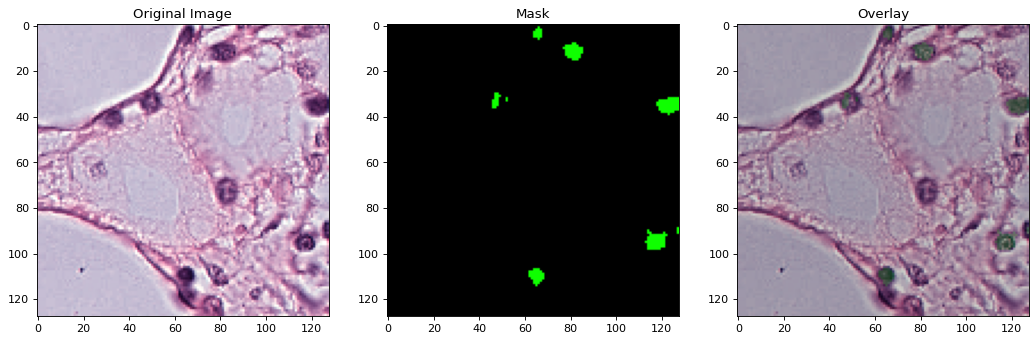

Ground truth


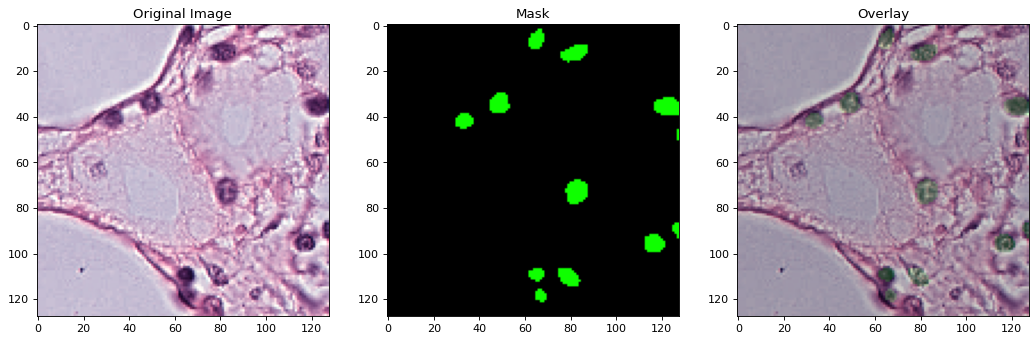

In [88]:
# Visualize the results

# Predictions
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
sample = Sample()
sample.set_image(image)
sample.set_mask(mask)
print("Predictions")
sample.show(with_mask=True)

if ground_truth_mask is not None:
    gt_mask = cv2.imread(ground_truth_mask, cv2.IMREAD_GRAYSCALE)
    sample.set_mask(gt_mask)
    print("Ground truth")
    sample.show(with_mask=True)